# Heading decoding

Our claim is those networks which are better at representing heading in sequences (better at decoding) are also more suited to match representations in the dorsal visual stream. To show this is the case, we need to:

* Load the fits
* Find the best iteration for each network, layer.
* Subselect the right, valid layers
* Compare the performance of different layers of the decoder at different times during the optimization to their performance.

In [56]:
import os
import pandas as pd
import wandb
from tqdm import tqdm

api = wandb.Api()

runs = api.runs("pmin/crcns-train_heading.py", 
                {"$and": 
                 [
                     {"state": "finished"},
                ]
                }
               )

features = {}
heading_results = []
for run in tqdm(runs):
    if run.config['features'] in features:
        continue
    
    try:
        os.remove('tuning_loss.npy')
    except FileNotFoundError:
        pass
    
    try:
        os.remove('report_loss.npy')
    except FileNotFoundError:
        pass
    
    for f in run.files():
        f.download(replace=True)

    try:
        tuning_loss = np.load('tuning_loss.npy')
    except FileNotFoundError:
        continue
        
    report_loss = np.load('report_loss.npy')
    
    try:
        layer_names = sorted(run.summary['best_report_loss'].keys())
    except:
        layer_names = [f'layer{i:02d}' for i in range(tuning_loss.shape[0])]
    
    best_report_loss = np.zeros((tuning_loss.shape[0], tuning_loss.shape[2]))
    for i in range(tuning_loss.shape[0]):
        minpos = tuning_loss[i, :, :].mean(axis=1).argmin()
        best_report_loss[i, :] = report_loss[i, minpos, :]
    
    heading_results += [
        {'features': run.config['features'],
         'layer_name': name,
         'heading_loss': best_report_loss[i, :].mean(),
         'heading_loss_pitch': best_report_loss[i, 0].mean(),
         'heading_loss_yaw': best_report_loss[i, 1].mean(),
         'heading_loss_rotation_pitch': best_report_loss[i, 2].mean(),
         'heading_loss_rotation_yaw': best_report_loss[i, 3].mean(),
         'heading_loss_speed': best_report_loss[i, 4].mean(),
        } for i, name in enumerate(layer_names)
    ]
    features[run.config['features']] = 1
    
df_heading = pd.DataFrame(heading_results)

100%|██████████| 17/17 [00:30<00:00,  1.80s/it]


In [57]:
df_heading

,features,layer_name,heading_loss,heading_loss_pitch,heading_loss_yaw,heading_loss_rotation_pitch,heading_loss_rotation_yaw,heading_loss_speed
0,I3D,layer00,3.163408,2.502536,3.705034,2.126441,3.089627,4.393403
1,I3D,layer01,3.130249,2.516052,3.728760,2.048092,2.923775,4.434566
2,I3D,layer02,3.211533,2.609058,3.776825,2.103789,3.039051,4.528940
3,I3D,layer03,3.180498,2.564221,3.791449,2.068312,2.969732,4.508778
4,I3D,layer04,3.099976,2.519368,3.742247,2.001397,2.831500,4.405370
...,...,...,...,...,...,...,...,...
90,cpc_01,layer04,2.585445,2.472202,3.554297,1.139845,1.585714,4.175165
91,cpc_01,layer06,2.600405,2.462635,3.575049,1.170548,1.622192,4.171598
92,cpc_01,layer08,2.670085,2.460824,3.609590,1.253068,1.796242,4.230702
93,cpc_01,layer10,2.775955,2.503787,3.628002,1.308482,2.109606,4.329899


In [34]:
results.keys()

dict_keys(['I3D', 'r2plus1d_18', 'mc3_18', 'r3d_18', 'MotionNet', 'gaborpyramid3d_motionless', 'gaborpyramid3d', 'airsim_04', 'cpc_02', 'cpc_01'])

In [2]:
import numpy as np
import matplotlib.pyplot as plt

loss = np.load('report_loss.npy')
plt.plot(loss.shape

(18, 50, 5)

In [88]:
import sys
sys.path.append('../')
from loaders import airsim

loader = airsim.AirSim('/mnt/e/data_derived/airsim/batch2/', regression=False)

(array([449., 470., 485., 452., 469., 458., 482., 488., 426., 444., 457.,
        434., 479., 479., 451., 474., 462., 454., 467., 461., 470., 447.,
        443., 472., 480., 433., 446., 471., 458., 444., 496., 490., 446.,
        423., 438., 465., 434., 461., 473., 436., 461., 449., 427., 427.,
        435., 431., 431., 424., 399., 423., 428., 444., 437., 446., 386.,
        420., 390., 422., 460., 432., 415., 396., 409., 382., 413., 393.,
        392., 406., 417., 358., 407., 392.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72]),
 <BarContainer object of 72 artists>)

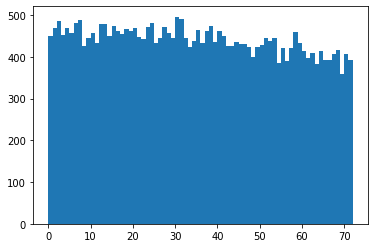

In [99]:
A = np.array([x['labels'] for x in loader.sequence])
plt.hist(A[:, 4], np.arange(73))